In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pickle
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import check_random_state
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

In [63]:
data = pd.read_csv('./data/processed_data.csv', index_col=0)
data.index = pd.to_datetime(data.index)

## Generate Feature

In [64]:
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['day_of_month'] = data.index.day
data['day_of_year'] = data.index.dayofyear
data['month'] = data.index.month
data['quarter'] = data.index.quarter
data['year'] = data.index.year

In [65]:
# data['peak_hour'] = (data['hour'] >= 8) & (data['hour'] <= 21)

In [66]:
data['peak_hour'] = 0

data.loc[((data['hour'] >= 8) & (data['hour'] <= 14)) |((data['hour'] >= 18) & (data['hour'] <= 21)),'peak_hour'] = 2

data.loc[(data['hour'] >= 15) & (data['hour'] <= 17),'peak_hour'] = 1

In [67]:
data['total load 1-month lag'] = data['total load actual'].shift(24*30)
data['total load 1-year lag']  = data['total load actual'].shift(24*365)

data['total load 1-year lag'] = data['total load 1-year lag'].fillna(data['total load 1-month lag'])
data['total load 1-year lag'] = data['total load 1-year lag'].fillna(data['total load 1-year lag'].mean())

data['total load 1-month lag'] = data['total load 1-month lag'].fillna(data['total load 1-month lag'].mean())

In [7]:
# # data['total load 1-hour lag']   = data['total load actual'].shift(1)
# # data['total load 1-day lag']   = data['total load actual'].shift(24)
# data['total load 1-week lag']  = data['total load actual'].shift(24*7)
# data['total load 1-month lag'] = data['total load actual'].shift(24*30)
# data['total load 1-year lag']  = data['total load actual'].shift(24*365)

# data['total load 1-year lag'] = data['total load 1-year lag'].fillna(data['total load 1-month lag'])
# data['total load 1-year lag'] = data['total load 1-year lag'].fillna(data['total load 1-week lag'])
# # data['total load 1-year lag'] = data['total load 1-year lag'].fillna(data['total load 1-day lag'])
# # data['total load 1-year lag'] = data['total load 1-year lag'].fillna(data['total load 1-hour lag'])
# data['total load 1-year lag'] = data['total load 1-year lag'].fillna(data['total load 1-year lag'].mean())


# data['total load 1-month lag'] = data['total load 1-month lag'].fillna(data['total load 1-week lag'])
# # data['total load 1-month lag'] = data['total load 1-month lag'].fillna(data['total load 1-day lag'])
# # data['total load 1-month lag'] = data['total load 1-month lag'].fillna(data['total load 1-hour lag'])
# data['total load 1-month lag'] = data['total load 1-month lag'].fillna(data['total load 1-month lag'].mean())

# # data['total load 1-week lag'] = data['total load 1-week lag'].fillna(data['total load 1-day lag'])
# # data['total load 1-week lag'] = data['total load 1-week lag'].fillna(data['total load 1-hour lag'])
# data['total load 1-week lag'] = data['total load 1-week lag'].fillna(data['total load 1-week lag'].mean())

# # data['total load 1-day lag'] = data['total load 1-day lag'].fillna(data['total load 1-hour lag'])
# # data['total load 1-day lag'] = data['total load 1-day lag'].fillna(data['total load 1-day lag'].mean())

# # data['total load 1-hour lag'] = data['total load 1-hour lag'].fillna(data['total load 1-hour lag'].mean())

In [68]:
data['avg_temp'] = np.mean(data[['temp_Barcelona', 'temp_Bilbao', 'temp_Madrid', 'temp_Seville', 'temp_Valencia']], axis=1)

In [69]:
X_col = [col for col in data.columns if ('forecast' not in col) and (col != 'total load actual')]
X = data[X_col]
y = data['total load actual']

In [70]:
train_percent = 0.8
train_size = int(0.8*len(X))

In [71]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [72]:
scaler_X.fit(X[:train_size])
scaler_y.fit(pd.DataFrame(y[:train_size]))

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [73]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(pd.DataFrame(y))

X_norm_train, y_norm_train = X_norm[:train_size], y_norm[:train_size]

## Check Feature Importance

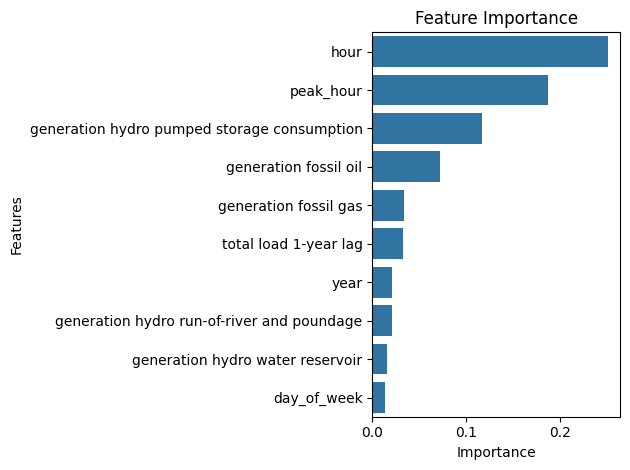

In [74]:
model = xgb.XGBRegressor()
model.fit(X_norm_train, y_norm_train)

importances = model.feature_importances_

# Plot the features importance using a barplot
feature_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:10])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.tight_layout()

In [121]:
feature_imp

hour                                                         0.251539
peak_hour                                                    0.187603
generation hydro pumped storage consumption                  0.116745
generation fossil oil                                        0.072005
generation fossil gas                                        0.034110
                                                               ...   
weather_description_shower sleet_Bilbao                      0.000000
weather_description_sleet_Bilbao                             0.000000
weather_description_snow_Bilbao                              0.000000
weather_description_light intensity shower rain_Barcelona    0.000000
weather_description_snow_Barcelona                           0.000000
Length: 232, dtype: float32

In [75]:
X_norm_train, X_norm_test = X_norm[:train_size], X_norm[train_size:]
y_norm_train, y_norm_test = y_norm[:train_size], y_norm[train_size:]

In [76]:
# 3.2 Convert the data into DMatrix, which is a data storage used by XGBoost Algorithm, optimized for both memory efficiency and training speed
D_train = xgb.DMatrix(X_norm_train, label=y_norm_train)
D_test = xgb.DMatrix(X_norm_test, label=y_norm_test)

In [77]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
import numpy as np

cv = TimeSeriesSplit(n_splits=15)

pipeline = Pipeline([
    ('selector', SelectFromModel(xgb.XGBRegressor(n_estimators=100, random_state=9))),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', nthread=-1))
])

grid = GridSearchCV(
    estimator=pipeline,
    param_grid={
        'model__n_estimators': np.arange(70, 170, 20),
        'model__max_depth': [3, 4, 5],
        'model__learning_rate': np.arange(0.05, 0.15, 0.02),
    },
    cv=cv,
    scoring='explained_variance',
    verbose=3,
    error_score='raise'
)

grid.fit(X_norm_train, y_norm_train)

print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)

# Predict
y_pred = grid.predict(X_norm_test)


Fitting 15 folds for each of 75 candidates, totalling 1125 fits
[CV 1/15] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=70;, score=0.743 total time=   0.6s
[CV 2/15] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=70;, score=0.797 total time=   0.6s
[CV 3/15] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=70;, score=0.801 total time=   0.7s
[CV 4/15] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=70;, score=0.840 total time=   0.7s
[CV 5/15] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=70;, score=0.798 total time=   0.8s
[CV 6/15] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=70;, score=0.785 total time=   0.9s
[CV 7/15] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=70;, score=0.819 total time=   0.9s
[CV 8/15] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=70;, score=0.828 total time=   1.2s


In [78]:
selected_boolean = grid.best_estimator_['selector'].get_support()
selected_features = np.array(X.columns)[grid.best_estimator_['selector'].get_support()]
print("Selected Features: ", selected_features)

Selected Features:  ['generation fossil gas' 'generation fossil hard coal'
 'generation fossil oil' 'generation hydro pumped storage consumption'
 'generation hydro run-of-river and poundage'
 'generation hydro water reservoir' 'generation nuclear'
 'generation other' 'generation solar' 'temp_Barcelona'
 'temp_max_Barcelona' 'wind_speed_Bilbao' 'rain_1h_Bilbao'
 'temp_min_Madrid' 'wind_speed_Madrid'
 'weather_description_light intensity drizzle_Madrid' 'hour' 'day_of_week'
 'day_of_month' 'day_of_year' 'year' 'peak_hour' 'total load 1-year lag'
 'avg_temp']


In [94]:
selected_features

array(['generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation solar', 'temp_Barcelona',
       'temp_max_Barcelona', 'wind_speed_Bilbao', 'rain_1h_Bilbao',
       'temp_min_Madrid', 'wind_speed_Madrid',
       'weather_description_light intensity drizzle_Madrid', 'hour',
       'day_of_week', 'day_of_month', 'day_of_year', 'year', 'peak_hour',
       'total load 1-year lag', 'avg_temp'], dtype=object)

In [80]:
best_params = grid.best_params_

print("best_params: ", best_params)
pipeline.set_params(**best_params)
pipeline.fit(X_norm_train, y_norm_train)


with open('xgboost_with_monthly_lag_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

# # Load the pipeline later
# with open('xgboost_with_monthly_lag_pipeline.pkl', 'rb') as f:
#     loaded_pipeline = pickle.load(f)

# # You can then access the XGBoost model and its parameters
# print(loaded_pipeline.named_steps['model'].get_params())

best_params:  {'model__learning_rate': np.float64(0.11000000000000001), 'model__max_depth': 5, 'model__n_estimators': np.int64(150)}


## Check Model Results

In [110]:
train_pred_y = pipeline.predict(X_norm_train)
test_pred_y = pipeline.predict(X_norm_test)

In [112]:
true_test_y = scaler_y.inverse_transform(y_norm_test)
true_train_y = scaler_y.inverse_transform(y_norm_train)
true_pred_train_y = scaler_y.inverse_transform(train_pred_y.reshape(-1, 1))
true_pred_y = scaler_y.inverse_transform(test_pred_y.reshape(-1, 1))

In [117]:
print("Training Mean Absolute Percentage Error: {}".format(mean_absolute_percentage_error(true_train_y, true_pred_train_y)*100))
print("Testing Mean Absolute Percentage Error: {}".format(mean_absolute_percentage_error(true_test_y, true_pred_y)*100))

Training Mean Absolute Percentage Error: 2.4160997637683432
Testing Mean Absolute Percentage Error: 4.134612517605802


In [118]:
train_mse = mean_squared_error(true_train_y, true_pred_train_y)
train_var_y = np.var(true_pred_train_y)
train_explained_var = 1 - train_mse / train_var_y

test_mse = mean_squared_error(true_test_y, true_pred_y)
test_var_y = np.var(true_pred_y)
test_explained_var = 1 - test_mse / test_var_y

print("Training Explained Variance:", train_explained_var)
print("Testing Explained Variance:", test_explained_var)


Training Explained Variance: 0.95907044
Testing Explained Variance: 0.8760105


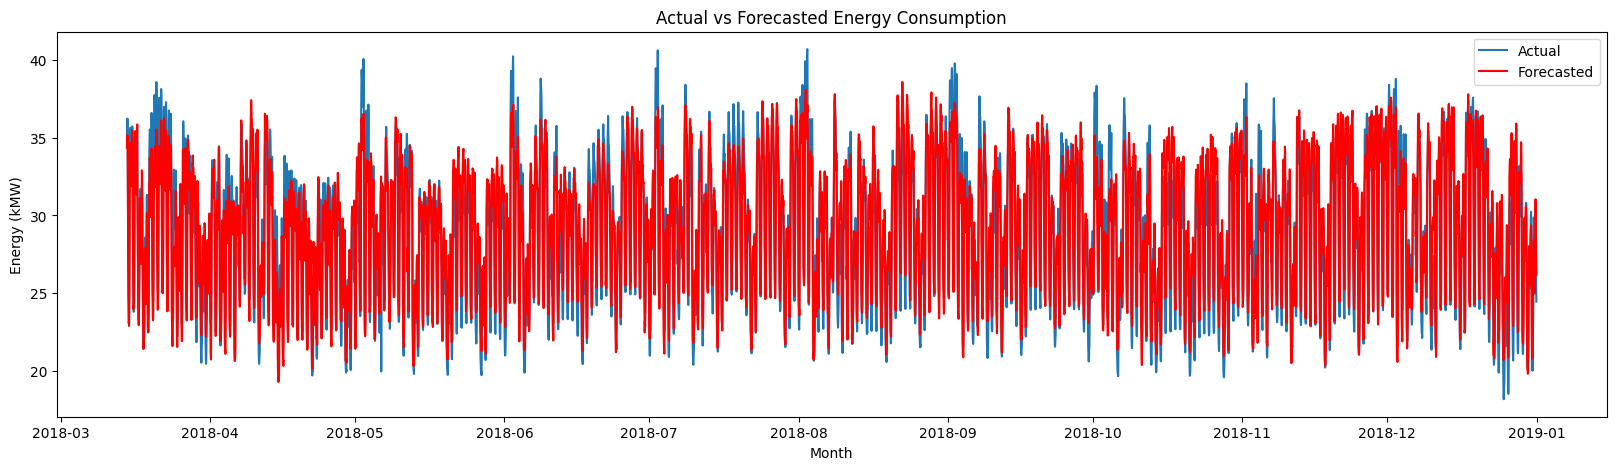

In [106]:
plt.figure(figsize=(20, 5))
plt.plot(y[train_size:].index, true_test_y/1000, label='Actual')
plt.plot(y[train_size:].index, true_pred_y/1000, label='Forecasted', color='red')
plt.title("Actual vs Forecasted Energy Consumption")
plt.xlabel("Month")
plt.ylabel("Energy (kMW)")
plt.legend()
plt.show()


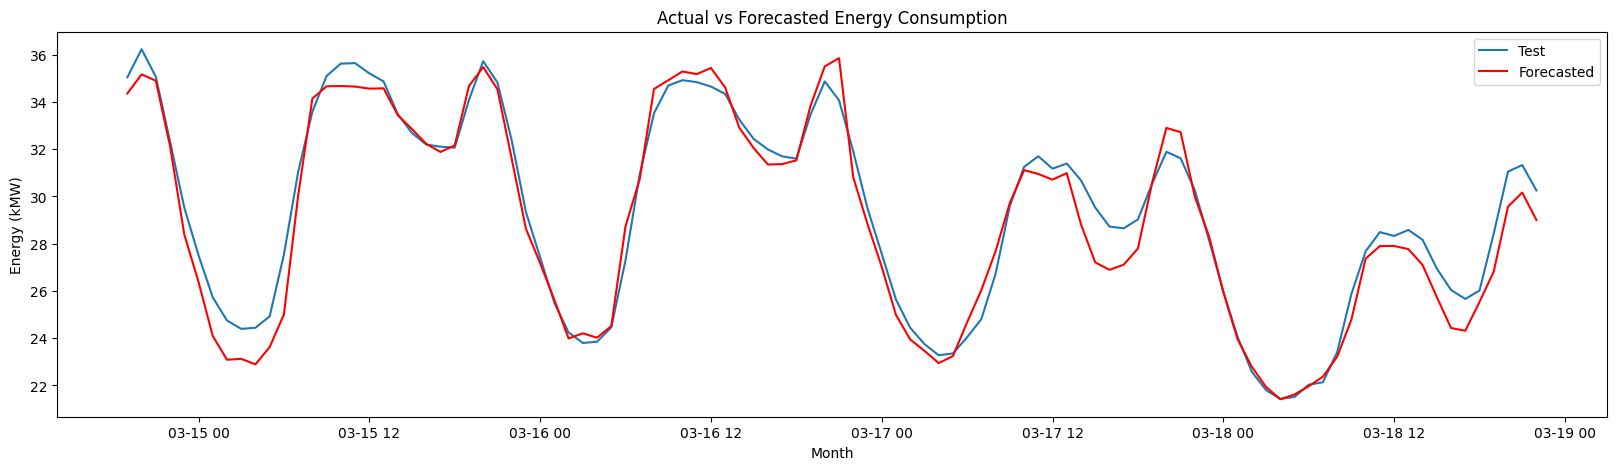

In [109]:
plt.figure(figsize=(20, 5))
plt.plot(y[train_size:train_size+100].index, true_test_y[:100]/1000, label='Test')
plt.plot(y[train_size:train_size+100].index, true_pred_y[:100]/1000, label='Forecasted', color='red')
plt.title("Actual vs Forecasted Energy Consumption")
plt.xlabel("Month")
plt.ylabel("Energy (kMW)")
plt.legend()
plt.show()


In [88]:
plt.figure(figsize=(40, 20), dpi=1000)  # large and high DPI
xgb.plot_tree(pipeline['model'], num_trees=0, rankdir='TB')
plt.savefig("xgb_tree_291125.png", dpi=1000, bbox_inches='tight')
plt.close()

/usr/local/lib/python3.11/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(
Python(39725) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


<Figure size 40000x20000 with 0 Axes>

In [122]:
selected_features

array(['generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation solar', 'temp_Barcelona',
       'temp_max_Barcelona', 'wind_speed_Bilbao', 'rain_1h_Bilbao',
       'temp_min_Madrid', 'wind_speed_Madrid',
       'weather_description_light intensity drizzle_Madrid', 'hour',
       'day_of_week', 'day_of_month', 'day_of_year', 'year', 'peak_hour',
       'total load 1-year lag', 'avg_temp'], dtype=object)

---

## Load and Check trained Model

Monthly lag included

In [125]:
with open('xgboost_with_monthly_lag_pipeline.pkl', 'rb') as f:
    loaded_pipeline = pickle.load(f)

loaded_pipeline.fit(X_norm_train, y_norm_train)

train_pred_y = loaded_pipeline.predict(X_norm_train)
test_pred_y = loaded_pipeline.predict(X_norm_test)

print("Training Mean Squared Error: {}".format(mean_squared_error(y_norm_train, train_pred_y)))
print("Testing Mean Squared Error: {}".format(mean_squared_error(y_norm_test, test_pred_y)))

Training Mean Squared Error: 0.001526467581588711
Testing Mean Squared Error: 0.004246633450712701


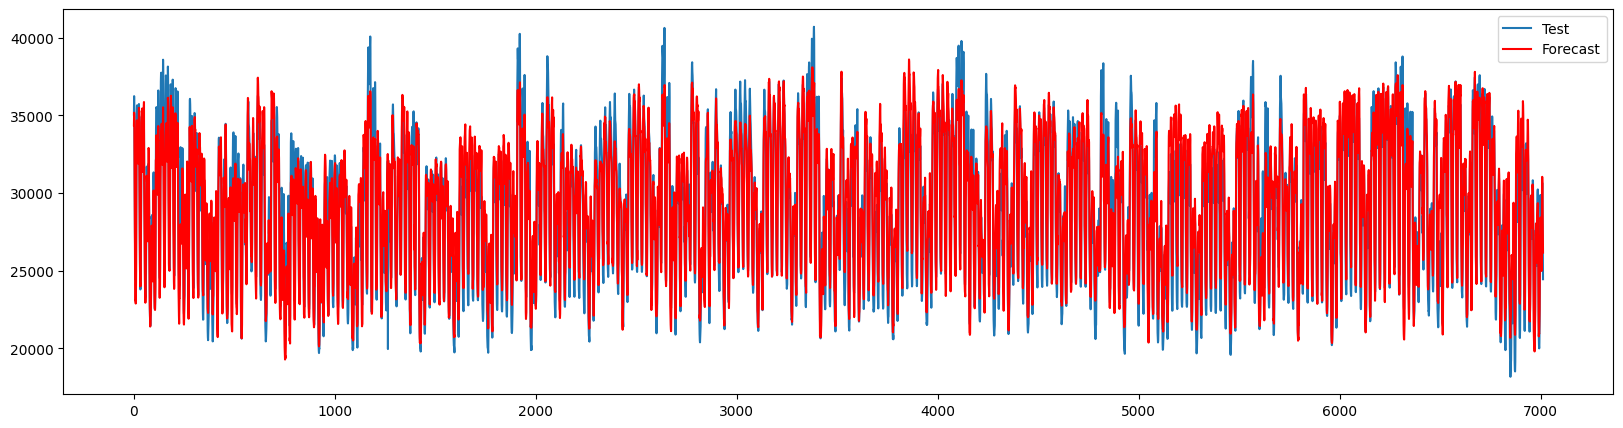

In [126]:
plt.figure(figsize=(20, 5))
plt.plot(true_test_y, label='Test')
plt.plot(true_pred_y, label='Forecast', color='red')
plt.legend()
plt.show()

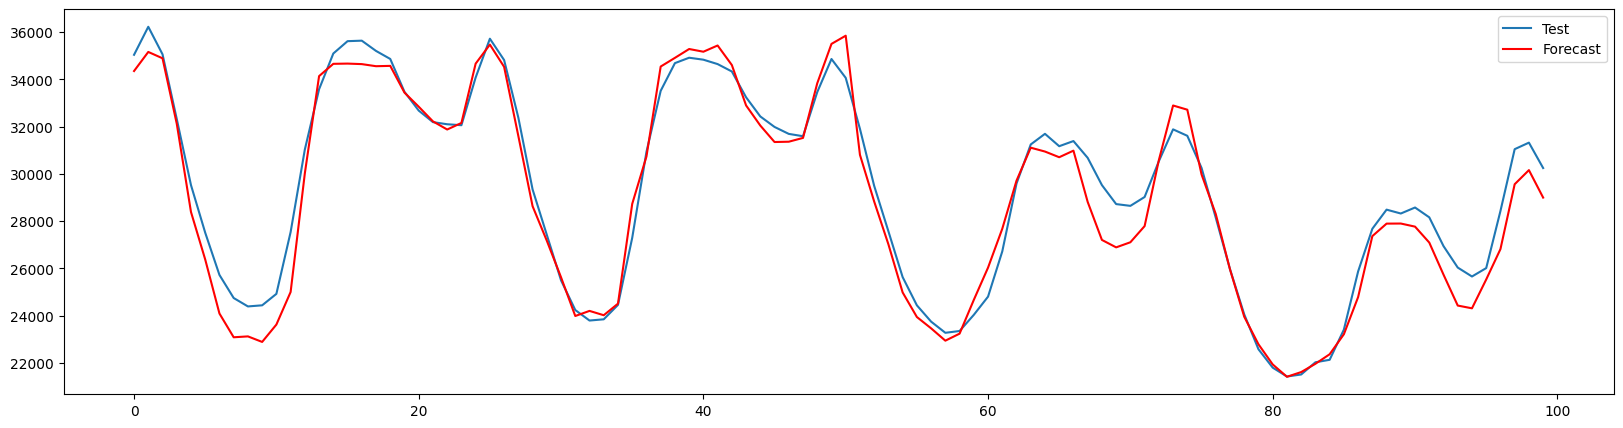

In [127]:
plt.figure(figsize=(20, 5))
plt.plot(true_test_y[:100], label='Test')
plt.plot(true_pred_y[:100], label='Forecast', color='red')
plt.legend()
plt.show()

In [129]:
train_mse = mean_squared_error(true_train_y, true_pred_train_y)
train_var_y = np.var(true_pred_train_y)
train_explained_var = 1 - train_mse / train_var_y

test_mse = mean_squared_error(true_test_y, true_pred_y)
test_var_y = np.var(true_pred_y)
test_explained_var = 1 - test_mse / test_var_y

print("Training Explained Variance:", train_explained_var)
print("Testing Explained Variance:", test_explained_var)


Training Explained Variance: 0.95907044
Testing Explained Variance: 0.8760105
